# GROUP 66 - ML ASSIGNMENT : NAIVE BAYES CLASSIFIER 

#### Abhinav Bohra | 18CS30049   
#### Animesh Jain   | 18CS10004

### F Dataset : Task is to predict label of target variable ->  'severity_county_5-day'

# **Data Pre-processing**

In [1]:
def fetchData():
    '''
     Reads a csv files into a dataframe and returns it
    '''
    data = pd.read_csv('Train_F.csv') 
    return data

Part 1 : Randomly divide the data into 80% for training and 20% for testing

In [2]:
def splitData(data,target_var,splitRatio=None): 
    '''
    Takes dataframe and target variable name as input and splits into X and Y sets using target_var
    Futher splits X into X_train , X_test
    Futher splits Y into Y_train , Y_test
    Splitting done as per input split ratio
    Default Split Ratio -> [train : test] = [80 : 20]
    return attributes(column name) of set X , labels (unique class in set Y) and X_train,X_test,Y_train,Y_test as dataframe
    '''

    #data = data.sample(frac=1)                            #Shuffles the dataset
    Y = data[target_var].reset_index(drop=True)
    X = data.copy(deep=True)
    X.drop([target_var], axis='columns', inplace=True)
    
    if(X is None or Y is None):
        print("Error : X or Y cannot be of NoneType.")
        return
    
    if(len(X)!= len(Y)):
        print("Error : X and Y should be of same dimension. ")
        return
        
    if(splitRatio is not None and (splitRatio <= 0 or splitRatio >= 1) ):
        print("Error : splitRatio should be between 0 and 1. ")
        return
                             
    splitRatio = splitRatio if splitRatio is not None else 0.80     #splitRatio1 default value = 0.80
        
    #Split into trainset and testset        
    
    cutIndex = int (splitRatio*len(X))

    X_train = X[:cutIndex]
    X_test  = X[cutIndex:]

    Y_train = Y[:cutIndex]
    Y_test  = Y[cutIndex:]

    attributes = data.columns[:-1]
    labels     = data[target_var].unique()
    return attributes, labels, X_train, X_test, Y_train.to_frame(), Y_test.to_frame()

Part 1 (a) : Handle the missing values in both train and test set.

In [3]:
def fillMissingValues(df):
    '''
     Fills missing values in a categorical attribute by mode of the attribute
     Fills missing values in a continous   attribute by mean of the attribute
    '''

    cateogry_columns=df.select_dtypes(include=['object']).columns.tolist()
    continous_columns=df.select_dtypes(include=['int64','float64']).columns.tolist()
  
    for column in df:
        if df[column].isnull().any():
            if(column in cateogry_columns):
                df[column]=df[column].fillna(df[column].mode()[0])
            else:
                df[column]=df[column].fillna(df[column].mean)

    return df

Part 1(b) Encode categorical variables using appropriate encoding method 

In [4]:
def encode(df):
    '''
     Encoding Method used for Categorical Varaibles : Label Encoding from sk-learn
    '''
    le= LabelEncoder()
  
    cateogry_columns=df.select_dtypes(include=['object']).columns.tolist()
    for column in cateogry_columns:
        df[column] = le.fit_transform(df[column])
  
    return df

Part 1 (c) Compute 5-fold cross validation on the training set 

In [5]:
def cross_validation_split(X,Y,startIndex,endIndex):
    '''
       Splits X & Y according to startIndex and endIndex 
       Returns the partitions
    '''
    X_test = X.iloc[startIndex:endIndex]
    Y_test = Y.iloc[startIndex:endIndex]
    X_train = X.drop(X.index[startIndex:endIndex])
    Y_train = Y.drop(Y.index[startIndex:endIndex])
    return X_train, X_test, Y_train, Y_test

def crossValidation(X,Y,k_folds):
    '''
       Takes set X & Y as input
       Takes k_folds as input for dividing sets X & Y into k parts
       Iterates k times and in each iteration sets one part as test-set & other (k-1) parts as train-set
       Computes accuacy in each iteration
       Returns summarizeData & prob_class corresponding to the set with maximum accuracy
    '''
    foldSize = int (len(X)/k_folds)
    maxAcc_CV = 0
    best_summarizeData = dict()
    best_prob_class = dict()
    for i in range(0,k_folds):
        startIndex = i*foldSize
        endIndex   = (i+1)*foldSize - 1
        X_train, X_test, Y_train, Y_test = cross_validation_split(X,Y,startIndex,endIndex)
        target = Y_train.columns[0]
        labels = Y_train[target].unique()
        attributes = X_train.columns
        summarizeData,prob_class = train(X_train,Y_train)
        preds_test = getPredictions(X_test,summarizeData,prob_class,labels,attributes)
        acc_CV = getAccuracy(preds_test,Y_test.to_numpy())

    if acc_CV > maxAcc_CV :
        maxAcc_CV = acc_CV
        best_summarizeData = summarizeData
        best_prob_class    = prob_class

    return best_summarizeData, best_prob_class

**Some Helper Functions to compute mathematical terms used by classifier**

In [6]:
#Math Functions
import math
from math import sqrt, pi, exp
  
def mean(x):
    '''
      Computes mean of input numbers
    '''
    return x.mean()

def std(x):
    '''
      Computes standard deviation of input numbers
    '''
    return x.std()

def gaussianPDF(x, mean, stdev):
    '''
      Computes Gaussian Probability density for input x , mean & standard deviations
    '''
    exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
    return (1 / (sqrt(2 * pi) * stdev)) * exponent

**train: Function to train classifier using training dataset**

In [7]:
def train(X_train,Y_train):
    '''
        Takes X_train & Y_train dataframes as argument
        Data Structures used to save parameters of trained model:-
        1.) summarizeData is a 3 dimensional dictionary that stores mean & standard deviation of each feature for given lebel class
        2.) prob_class is a dictionary that stores prior probability of each label class

        Returns summarizeData, prob_class dictionaries

        NOTE : Gaussian Probability Distribution is used to compute the probabilities
    '''
    target = Y_train.columns[0]
    labels = Y_train[target].unique()
   
    summarizeData=dict()
    prob_class=dict()
    for label in labels:
        prob_class[label] = (Y_train.iloc[(Y_train[target]==label).values].shape[0] + 1) / ( Y_train.shape[0] + len(labels) )
        summarizeFeature =dict()
        for feature in X_train.columns:
            mean_std=dict()
            mean_std['mean'] = mean(X_train.iloc[(Y_train[target]==label).values][feature])
            mean_std['std']  = std (X_train.iloc[(Y_train[target]==label).values][feature])
            summarizeFeature[feature] = mean_std 
    
        summarizeData[label] = summarizeFeature 
   
    return summarizeData,prob_class

**predict : Function to predict label(class) of input instance**

In [8]:
def predict(instance_X,summarizeData,prob_class,labels,attributes):
    '''
        Predicts the class labels for given instance X
        Conditional Independence of attributes is used to compute P(Class | instanceX)
        Let instance X be <x1, x2, x3> (for example)
        P(Class | instanceX) = P(Class) * P(x1 | Class) * P(x2 | Class) * P(x3 | Class) 
        The predicted class is the one having maximum probability among all the classes    
    '''
    prob_max =0
    predicted_label= None

    for label in labels:
        prob = prob_class[label]  #Prior Probability
        for attribute in attributes:
            std_dev = summarizeData[label][attribute]['std']
            mean    = summarizeData[label][attribute]['mean']
            x       = instance_X[attribute]
            if std_dev==0 or math.isnan(mean) or math.isnan(x):
                prob = prob * 1
            elif math.isnan(std_dev):
                prob = prob * (1)/(len(labels) + 3152)
            else:
                prob *= gaussianPDF(x, mean,std_dev)
        
        if prob > prob_max:
            prob_max = prob
            predicted_label = label

    return predicted_label

def getPredictions(test,summarizeData,prob_class,labels,attributes):
    preds=[]
    for i in range(0,len(test)):
        preds.append(predict(test.iloc[i],summarizeData,prob_class,labels,attributes))
  
    return preds

**getAccuracy : Function to calculate accuracy of classifier**

In [9]:
def getAccuracy(preds,labels):
    '''
      Computes fraction of samples correctly predicted by the model
    '''
    if len(preds) != len(labels):
        print("Shape of Actual label array & predicted label array should be same.")
        exit(1)
    correct_count=0
    for i in range(0,len(preds)):
        if(preds[i]==labels[i]):
            correct_count+=1

    return correct_count/len(preds)

***Main Model*** : Assembling all the functions

In [10]:
def model(df,target,splitRatio=None):
    '''
        Trains on training data, predicts on testing data & returns the accuracy of the model
    '''
    attributes, labels, X_train, X_test, Y_train, Y_test = splitData(df,target,splitRatio)
    summarizeData,prob_class = train(X_train,Y_train)
    preds_test = getPredictions(X_test,summarizeData,prob_class,labels,attributes)
    acc_test = getAccuracy(preds_test,Y_test.to_numpy())
    return acc_test

**Part 2 : Using Principal Component Analysis**

In [36]:
def findComponents(variance_arr):
    '''
      Finds number of components that preserve 95% of total variance
    '''
    totalVariance =0
    for v in variance_arr:
        totalVariance +=v
  
    ninetyFive_Variance = 0.95 * totalVariance  
    components=0
    varianceSum=0
    for v in variance_arr:
        if varianceSum < ninetyFive_Variance:
            varianceSum += v
            components +=1
        else:
            break
  
    print("No. of components selected by preserving 95% of total variance: ", components)
    return components
  

def applyPCA(X_train,X_test):
    '''
        Takes X set as input
        Extracts features using principal component anaylsis
        Fits and Transforms X_train, Only Transforms X_test
        Selects number of components by preserving 95% of total variance
        Returns new attributes , X_train & X_test (as dataframe) after keeping the selected extracted features
    '''
    #N=len(X_train.columns)
    N=10
    #Apply PCA 
    pca = PCA(n_components=N)                #Instantiate PCA from sci-kit learn
    X_train_PCA = pca.fit_transform(X_train) #Fit and Transform X_train
    X_test_PCA  = pca.transform(X_test)      #Only Transform X_test

    # Convert numpy arrays to DataFrame
    df_X_train_PCA = pd.DataFrame(data = X_train_PCA,columns=[str(x) for x in range(0,X_train_PCA.shape[1])])
    df_X_test_PCA  = pd.DataFrame(data = X_test_PCA,columns=[str(x) for x in range(0,X_test_PCA.shape[1] )])

    # Calcaute explained_variance_ratio_ and plot the scree plot
    variance_arr = pca.explained_variance_ratio_
    df_PCA = pd.DataFrame({'variance':variance_arr,'PC':['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']})
    sns.barplot(x='PC',y="variance",data=df_PCA)

    # select number of components by preserving 95% of total variance
    components = findComponents(variance_arr)

    ColsToDrop=list()  #Keep first #components columns
    while (N > components + 1):
        ColsToDrop.append(str(N-1))
        N=N-1

    #Dataframes after dropping (N- components) number of components
    df_X_train_PCA = df_X_train_PCA.drop(ColsToDrop,axis=1)
    df_X_test_PCA  = df_X_test_PCA.drop(ColsToDrop,axis=1)

    new_attributes = df_X_train_PCA.columns
    return new_attributes, df_X_train_PCA, df_X_test_PCA

**Part 3(a)** : Removing Outliers

In [12]:
def isOutlier(x,mean,std):
    '''
       A feature value is considered as an outlier if its value is
       greater than mean + 3 x standard deviation
    '''
    if x > mean + 3*std: 
        return True
    else:
        return False

def removeOutliers(df):
    '''
        Computes mean & standard deviation for each feature
        A sample having more than half the total features as outlier features are removed 
    '''
    featureStats=dict()
    for column in df.columns:
        mean_std=dict()
        mean_std['mean'] = mean(df[column])
        mean_std['std']  = std (df[column])
        featureStats[column]= mean_std
  
    drop_indices=list()
    for i in range(0,len(df)):
        outlyingValues=0
        for feature in df.columns:
              if isOutlier(df.iloc[i][feature],featureStats[feature]['mean'],featureStats[feature]['std']):
                    outlyingValues +=1

        if outlyingValues > len(df.columns)/2:
              drop_indices.append(i)

    df = df.drop(df.index[drop_indices])
    return df

**Part 3(b)** : Sequential backward selection method

In [13]:
def seqBackwardSelect(df,target):
    '''
         Sequential backward selection method is appliedin a recursive fashion toremove less informative/useful features. 
         The method starts with considering all the features in the dataset and computes the accuracy.
         In each iteration the feature whose absence improves the accuracy by maximum is dropped.
         We return to callee function when no such removals are possible i.e. accuracy cannot be improved further
         Final dataset with dropped features is returned
    '''

    current_features = df.columns[:-1]
    curr_acc = model(df,target,0.8) 
    bestdf=None
    for currfeature in current_features:
        tempdf  = df.drop([currfeature],axis=1)
        tempAcc = model(tempdf,target)
        if tempAcc > curr_acc:
            bestdf=tempdf
            curr_acc = tempAcc
    
    if bestdf is not None :
        return seqBackwardSelect(bestdf,target)
    else:
        return df

## **Assignment**

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

### **Part 1 : Data-preprocessing**

In [15]:
# Fetch data from system directory
data = fetchData()
# Shuffle the dataframe -'data'
data = data.sample(frac=1)
# Part 1(a) : Fill missing values in dataframe - 'data' 
data = fillMissingValues(data)
# Part 1(b) : Encode categorical variables using label encoding
data = encode(data)
# Split the dataset into 80% for training and 20% for testing
attributes, labels, X_train, X_test, Y_train, Y_test= splitData(data,data.columns[-1],0.8) # traget variable -> data.columns[-1] ('severity_county_5-day), splitRatio : 0.8
# Part 1(c) : Compute 5-fold cross validation on the training set 
summarizeData, prob_class = crossValidation(X_train,Y_train,5)
# Test model on original Test-set using best summarizeData & best prob_class obtained from cross validation step
preds = getPredictions(X_test,summarizeData,prob_class,labels,attributes)
# Calculate accuracy of the predictions using Y_test
accuracy = getAccuracy(preds,Y_test.to_numpy())
# Print Final Test- Set Accuracy
print("Final Test-set Accuracy of model after pre-processing data (Part 1) is : " + str(round(accuracy,3)*100) + "%.")  

Final Test-set Accuracy of model after pre-processing data (Part 1) is : 42.9%.


### **Part 2 : Principal Component Analysis**

No. of components selected by preserving 95% of total variance:  1
Final Test-set Accuracy of model after applying PCA (Part 2) is : 42.4%.
Plotting the graph for PCA ...


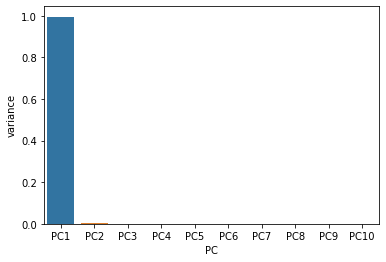

In [39]:
# Using data <- preprocessed data from part 1 
attributes, labels, X_train, X_test, Y_train, Y_test= splitData(data,data.columns[-1],0.8) 
# Apply PCA and extract new features
attributes_PCA, X_train_PCA, X_test_PCA = applyPCA(X_train,X_test)
# Compute 5-fold cross validation on the training set using the features extracted from PCA to train model
summarizeData, prob_class = crossValidation(X_train_PCA,Y_train,5)
# Test model on original Test-set using best summarizeData & best prob_class obtained from cross validation step
predsPCA = getPredictions(X_test_PCA,summarizeData,prob_class,labels,attributes_PCA)
# Calculate accuracy of the predictions using Y_test
accuracyPCA = getAccuracy(predsPCA,Y_test.to_numpy())
# Print Final Test- Set Accuracy
print("Final Test-set Accuracy of model after applying PCA (Part 2) is : " + str(round(accuracyPCA,3)*100) + "%.")  
print("Plotting the graph for PCA ...")   # Graph plotted by the function applyPCA(...)

##  **Part 2 : Principal Component Analysis Scatter Plot**

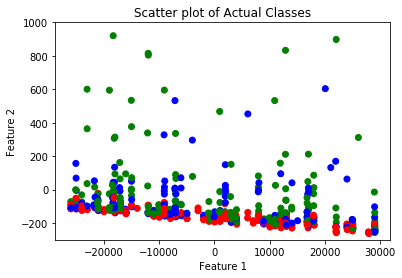

In [69]:
'''
    GROUP 66 - ML ASSIGNMENT : NAIVE BAYES CLASSIFIER
    Abhinav Bohra | 18CS30049
    Animesh Jain | 18CS10004
'''

#Visulaization of actual classes in Y_test
color=list()
for cat in Y_test['severity_county_5-day']:
    if cat == 1:
        color.append('red')
    elif cat == 2:
        color.append('blue')
    else :
        color.append('green')
        
plt.scatter( X_test_PCA['0'],X_test_PCA['1'],c=color)
plt.title('Scatter plot of Actual Classes')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.ylim(-300,1000)
plt.show();

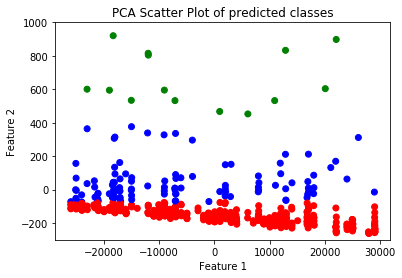

In [70]:
#Visulaization of predicted classes
color=list()
for cat in predsPCA:
    if cat == 1:
        color.append('red')
    elif cat == 2:
        color.append('blue')
    else :
        color.append('green')
y=np.zeros(len(X_test_PCA))        
plt.scatter( X_test_PCA['0'],X_test_PCA['1'],c=color)
plt.title('PCA Scatter Plot of predicted classes')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.ylim(-300,1000)
plt.show();

From the above graph, the decision boundary is evident. The classifier predicts all the points with Feature 2 value in range [-200,0] as category 1 (red dots). The middle region [0,200] forms the decision region corresponding to category 2 (blue dots).The upper region forms the decision region corresponding to category 3 (green dots).

Poor accuracy of the classifier is evident from the above scatter plot. It miss classifier points belonging to category 2 & 3 with Feature 2 value in range [-200,0] as category 1, resulting in high misclassification error and thus lower accuracy.

### **Part 3 : Removal of Outliers & Backward Selection Algorithm**

In [17]:
# Using data <- preprocessed data from part, removing outlier if its value is greater than mean + 3 x standard deviation 1 
noOutlier_data = removeOutliers(data)
# Using the sequential backward selection method to remove less informative/useful features
seqBS_data = seqBackwardSelect(noOutlier_data,noOutlier_data.columns[-1])
# Print the final set of features formed. 
print("Final Set of features after backward selection (Part 3.c) is : " )
print(str(seqBS_data.columns[:-1]))
# Set data using features obtained from backward selection algorithm
attributes_BS, labels_BS, X_train_BS, X_test_BS, Y_train_BS, Y_test_BS= splitData(seqBS_data,seqBS_data.columns[-1],0.8) 
# Compute 5-fold cross validation on the training set 
summarizeData, prob_class = crossValidation(X_train_BS,Y_train_BS,5)
# Test model on original Test-set using best summarizeData & best prob_class obtained from cross validation step
preds_BS = getPredictions(X_test_BS,summarizeData,prob_class,labels_BS,attributes_BS)
# Calculate accuracy of the predictions using Y_test
accuracy_BS = getAccuracy(preds_BS,Y_test_BS.to_numpy())
# Print Final Test- Set Accuracy
print("Final Test-set Accuracy of model after backward selection (Part 3.b) is : " + str(round(accuracy_BS,3)*100) + "%")

Final Set of features after backward selection (Part 3.c) is : 
Index(['countyfips', 'countyname', 'statename',
       'predicted_deaths_by_october_07', 'predicted_deaths_by_october_08',
       'predicted_deaths_by_october_09', 'predicted_deaths_by_october_10',
       'predicted_deaths_by_october_11', 'predicted_deaths_by_october_12'],
      dtype='object')
Final Test-set Accuracy of model after backward selection (Part 3.b) is : 43.5%


In [20]:
Y_test

,severity_county_5-day
2513,2
2514,2
2515,3
2516,1
2517,1
...,...
3137,3
3138,2
3139,3
3140,2


In [28]:
Y_test

,severity_county_5-day
2513,2
2514,2
2515,3
2516,1
2517,1
...,...
3137,3
3138,2
3139,3
3140,2


In [35]:
X_test_PCA

""
0
1
2
3
4
...
624
625
626
627


In [53]:
predsPCA

[2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 3,
 3,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 3,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 3,
 3,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 3,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 2,
 2,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 3,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
